# `strategic-fl-sim`: Twitter/Sent140 Demo Experiment

Demonstrating strategic federated learning with Byzantine client who uses sign flipping

In [11]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from twitterdataset import TwitterDataset

from models.bert import BertWithClassifier
from strategicflsim.agents import Client, Server
from strategicflsim.utils.actions import ScalarAction, SignFlipAction
from strategicflsim.utils.aggregation import get_aggregate
from strategicflsim.utils.evaluate import evaluate_with_ids
from strategicflsim.utils.metrics import NormMetrics
from strategicflsim.utils.selection import RandomSelector, RoundRobinSelector
from utils.config import load_config
from utils.io import generate_save_name

## Preparation/initialization

### Setup device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [3]:
config = {
    "experiment": {
        "id": "experiment_1",
        "save_dir": "./results/twitter",
    },
    "training": {
        "T": 500,
        "lr": 0.06,
        "local_steps": 1,
        "batch_size": 8,
        "eval_batch_size": 8,
    },
    "clients": {
        "n_players": 5,
        "alpha_0": 1.0,
        "alpha_1": 1.0,
        "beta_0": 0.0,
        "beta_1": 0.0,
    },
    "aggregation": {"method": "mean"},
    "data": {
        "train_path": "../../data/twitter/train.json",
        "test_path": "../../data/twitter/test.json",
        "min_samples": 15,
        "max_samples": 20,
    },
    "model": {"max_length": 512},
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  experiment:
    id: experiment_1
    save_dir: ./results/twitter
  training:
    T: 500
    lr: 0.06
    local_steps: 1
    batch_size: 8
    eval_batch_size: 8
  clients:
    n_players: 5
    alpha_0: 1.0
    alpha_1: 1.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/twitter/train.json
    test_path: ../../data/twitter/test.json
    min_samples: 15
    max_samples: 20
  model:
    max_length: 512


### Helper function

In [4]:
def freeze_bert_encoder(model):
    """Freeze BERT encoder layers, keep only classifier trainable."""
    for name, param in model.named_parameters():
        if "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False


def get_data(path: str):
    """Load data from JSON file."""
    with open(path, "r") as f:
        data = json.load(f)
        user_names = data["users"]
        data_dict = data["user_data"]
    return data_dict, user_names


### Loading the Sent140 data

In [5]:
print("\nLoading Twitter data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, user_names_test = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Test data: {len(user_names_test)} users")

# Verify consistency between train and test user names
usernames_diff = list(set(user_names) ^ set(user_names_test))
assert not usernames_diff, "Inconsistent usernames between test and train"

# DATA FILTERING
if "min_samples" in config["data"] and "max_samples" in config["data"]:
    subset = [
        user_name
        for user_name in user_names
        if config["data"]["min_samples"]
        <= len(data_dict[user_name]["y"])
        <= config["data"]["max_samples"]
    ]
    print(
        f"Filtered to {len(subset)} users with {config['data']['min_samples']}-{config['data']['max_samples']} samples"
    )

    user_names = subset
    data_dict = {key: data_dict[key] for key in subset}
    test_data_dict = {key: test_data_dict[key] for key in subset}


Loading Twitter data...
Training data: 254555 users
Test data: 254555 users
Filtered to 3415 users with 15-20 samples


### Creating a Server agent with BERT

In [6]:
print("\nCreating server...")
server_model = BertWithClassifier().to(device)

# Freeze BERT encoder, keep only classifier trainable
freeze_bert_encoder(server_model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in server_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in server_model.parameters())
print(
    f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.1f}%)"
)

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(
        [p for p in server_model.parameters() if p.requires_grad],
        lr=config["training"]["lr"],
    ),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
    agent_id="server",
)

print(f"Created server with {config['aggregation']['method']} aggregation")


Creating server...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 296,066 / 109,778,306 (0.3%)
Created server with mean aggregation


### Creating a group of Client agents

All but one clients are honest, one client is flipping the sign and scaling up the update.

In [7]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "malicious"
        print(f"  Client {i + 1}: BAD - {len(client_user_names)} users")
        action = SignFlipAction(alpha)
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"honest_{i}"
        print(f"  Client {i + 1}: GOOD - {len(client_user_names)} users")
        action = ScalarAction(alpha)

    train_dataset = TwitterDataset(
        client_user_names, data_dict, max_length=config["model"]["max_length"]
    )
    test_dataset = TwitterDataset(
        client_user_names, test_data_dict, max_length=config["model"]["max_length"]
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    client_model = BertWithClassifier().to(device)
    freeze_bert_encoder(client_model)

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(
            [p for p in client_model.parameters() if p.requires_grad],
            lr=config["training"]["lr"],
        ),
        action=action,
        agent_id=agent_id,
    )

    clients.append(client)


Creating clients...
  Client 1: GOOD - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2: GOOD - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3: GOOD - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 4: GOOD - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 5: BAD - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Run federated training

In [8]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

# os.makedirs("./results/twitter_byzantine", exist_ok=True)

server.train(
    clients=clients,
    T=config["training"]["T"],
    selector_fn=RoundRobinSelector(clients_per_round=3),
    metrics_fn=NormMetrics(
        save_path="./results/twitter_malicious_mean_50_cyclical",
        client_ids=[client.agent_id for client in clients],
    ),
)

print("Training completed!")


Starting federated training for 500 rounds...


Federated Training: 100%|██████████| 500/500 [08:42<00:00,  1.05s/it]

Training completed!


## Evaluate final performance

In [9]:
# This might be extremely slow if you're doing it locally, sorry :(

print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
honest_0: Accuracy = 0.5421, Loss = 0.8050
honest_1: Accuracy = 0.5422, Loss = 0.8058
honest_2: Accuracy = 0.5427, Loss = 0.8045
honest_3: Accuracy = 0.5497, Loss = 0.7953
malicious: Accuracy = 0.5604, Loss = 0.7781


In [3]:
final_loss_byz_50_cyclical = {'honest_0': 0.8049783568091989,
 'honest_1': 0.805795455127029,
 'honest_2': 0.8045499008589634,
 'honest_3': 0.7952712439777917,
 'malicious': 0.778088047079844}

In [4]:
final_loss_honest_trimmed_mean = {'good0': 0.6317868282868615,
 'good1': 0.6324625341418367,
 'good2': 0.6331604994545837,
 'good3': 0.6304965269079241,
 'bad': 0.6320478403256512}

In [5]:
final_loss_byz = {'honest_0': 0.7613396401177783,
 'honest_1': 0.7645969837718869,
 'honest_2': 0.7652058022405261,
 'honest_3': 0.7668703671594678,
 'malicious': 0.7848085331293299}

In [6]:
final_loss_honest = {'good0': 0.629045140054037,
 'good1': 0.6282356674256532,
 'good2': 0.6291968535219005,
 'good3': 0.6243903854022476,
 'bad': 0.6218717710612571}

In [7]:
final_loss_byz_trimmed_mean = {'honest_0': 0.6576824881097671,
 'honest_1': 0.6588273765137477,
 'honest_2': 0.6629763211437952,
 'honest_3': 0.6615212942647325,
 'malicious': 0.6661443263477881}

In [8]:
final_loss_honest_50_random = {'good0': 0.629045140054037,
 'good1': 0.6282356674256532,
 'good2': 0.6291968535219005,
 'good3': 0.6243903854022476,
 'bad': 0.6218717710612571}

In [9]:
final_loss_byz_50_random = {'honest_0': 0.6605045041676215,
 'honest_1': 0.6624414777163393,
 'honest_2': 0.6616696540920405,
 'honest_3': 0.6595896977533324,
 'malicious': 0.6619945747469311}

## Visualize training process

In [ ]:
sns.color_palette(palette="tab20c")

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

Figure saved as './results/twitter-random-trimmed.pdf'


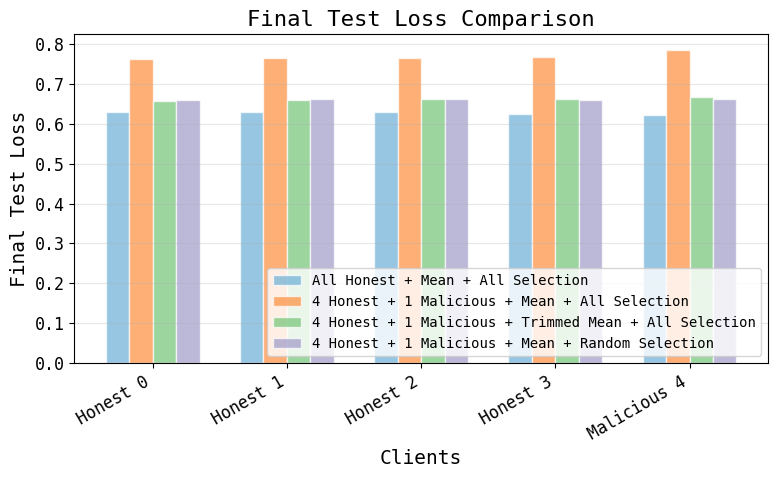

In [23]:
plt.rcParams.update(
    {
        "font.family": "monospace",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Color scheme
color_palette = sns.color_palette(palette="tab20c")
color_good = color_palette[1]  # light blue
color_byz = color_palette[5]  # light orange
color_byz_trimmed = color_palette[9]  # light orange
color_byz_random = color_palette[13]  # light orange


# Final loss comparison
client_ids = list(final_loss_honest.keys())
losses_honest_final = [float(final_loss_honest[cid]) for cid in client_ids]
losses_byz_final = [
    float(final_loss_byz[cid]) for cid in list(final_loss_byz.keys())
]
losses_byz_trimmed = [float(final_loss_byz_trimmed_mean[cid]) for cid in list(final_loss_byz_trimmed_mean.keys())]

losses_byz_random = [float(final_loss_byz_50_random[cid]) for cid in list(final_loss_byz_50_random.keys())]

x = np.arange(len(client_ids))
width = 0.175

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x - 1.5 * width,
    losses_honest_final,
    width,
    label="All Honest + Mean + All Selection",
    color=color_good,
    alpha=0.7,
    edgecolor="white",
)
ax.bar(
    x - 0.5 * width,
    losses_byz_final,
    width,
    label="4 Honest + 1 Malicious + Mean + All Selection",
    color=color_byz,
    alpha=0.7,
    edgecolor="white",
)
ax.bar(
    x + 0.5 * width,
    losses_byz_trimmed,
    width,
    label="4 Honest + 1 Malicious + Trimmed Mean + All Selection",
    color=color_byz_trimmed,
    alpha=0.7,
    edgecolor="white",
    # hatch="//",
)
ax.bar(
    x + 1.5 * width,
    losses_byz_random,
    width,
    label="4 Honest + 1 Malicious + Mean + Random Selection",
    color=color_byz_random,
    alpha=0.7,
    edgecolor="white",
    # hatch="x",
)

ax.set_xlabel("Clients")
ax.set_ylabel("Final Test Loss")
ax.set_title("Final Test Loss Comparison")
ax.set_xticks(x)

for i in range(len(client_ids) - 1):
    client_ids[i] = f"Honest {i}"
client_ids[-1] = "Malicious 4"

ax.set_xticklabels(client_ids, rotation=30, ha="right")
ax.legend(loc="lower right", fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_filename = "./results/twitter-random-trimmed"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

Figure saved as './results/twitter_comparison.pdf'


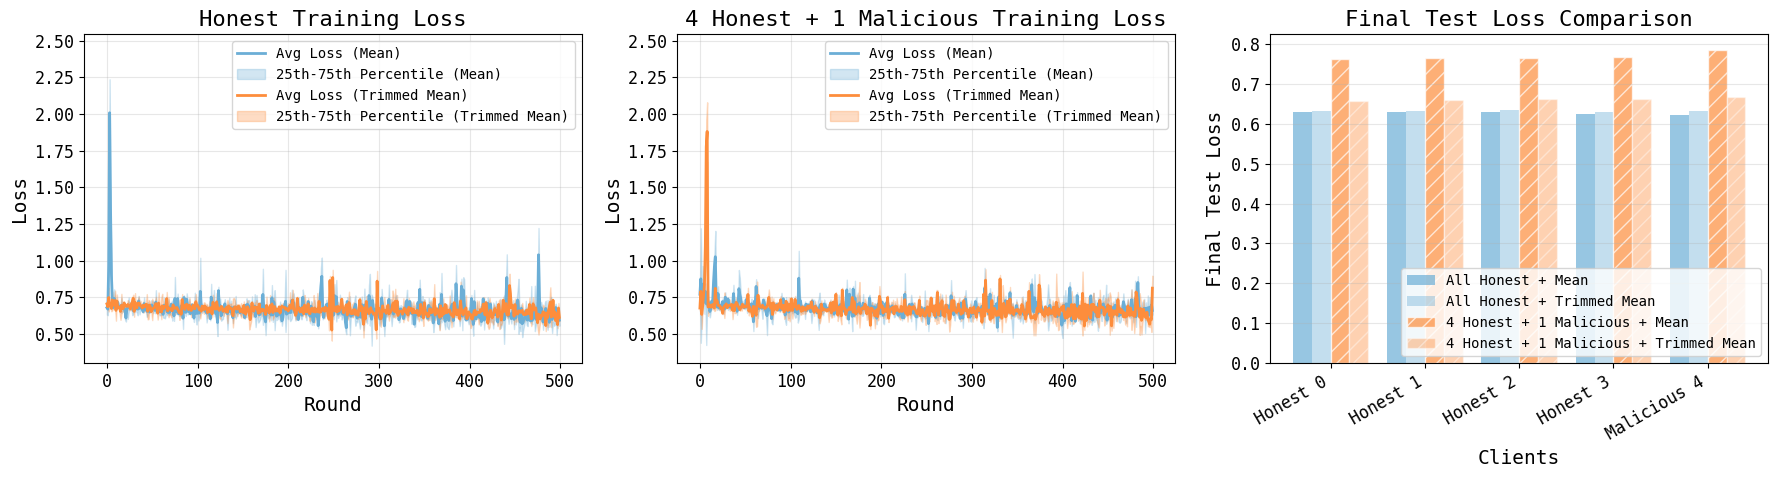

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def load_run_data(save_name):
    """Load metrics for a single run."""
    losses_df = pd.read_csv(f"{save_name}_losses.csv")
    rounds = losses_df['round'].values
    losses_array = losses_df.drop('round', axis=1).values
    return rounds, losses_array

plt.rcParams.update({
    "font.family": "monospace",
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Color scheme
color_palette = sns.color_palette(palette='tab20c')
color_mean = color_palette[1]
color_trimmed = color_palette[5]

# Load all runs
rounds_honest, losses_honest = load_run_data("./results/twitter_honest")
rounds_honest_tm, losses_honest_tm = load_run_data("./results/twitter_honest_trimmed_mean")
rounds_byz, losses_byz = load_run_data("./results/twitter_malicious_mean")
rounds_byz_tm, losses_byz_tm = load_run_data("./results/twitter_malicious_trimmed_mean")

# Calculate statistics
mean_honest = losses_honest.mean(axis=1)
p25_honest = np.percentile(losses_honest, 25, axis=1)
p75_honest = np.percentile(losses_honest, 75, axis=1)

mean_honest_tm = losses_honest_tm.mean(axis=1)
p25_honest_tm = np.percentile(losses_honest_tm, 25, axis=1)
p75_honest_tm = np.percentile(losses_honest_tm, 75, axis=1)

mean_byz = losses_byz.mean(axis=1)
p25_byz = np.percentile(losses_byz, 25, axis=1)
p75_byz = np.percentile(losses_byz, 75, axis=1)

mean_byz_tm = losses_byz_tm.mean(axis=1)
p25_byz_tm = np.percentile(losses_byz_tm, 25, axis=1)
p75_byz_tm = np.percentile(losses_byz_tm, 75, axis=1)

# Shared y-axis
all_losses = np.concatenate([losses_honest.flatten(), losses_honest_tm.flatten(),
                              losses_byz.flatten(), losses_byz_tm.flatten()])
y_min, y_max = all_losses.min(), all_losses.max()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Honest training (mean vs trimmed mean)
axes[0].plot(rounds_honest, mean_honest, label="Avg Loss (Mean)", color=color_mean, linewidth=2)
axes[0].fill_between(rounds_honest, p25_honest, p75_honest, alpha=0.3, color=color_mean, label="25th-75th Percentile (Mean)")
axes[0].plot(rounds_honest_tm, mean_honest_tm, label="Avg Loss (Trimmed Mean)", color=color_trimmed, linewidth=2)
axes[0].fill_between(rounds_honest_tm, p25_honest_tm, p75_honest_tm, alpha=0.3, color=color_trimmed, label="25th-75th Percentile (Trimmed Mean)")
axes[0].set_ylim(y_min, y_max)
axes[0].set_title("Honest Training Loss")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot 2: Byzantine training (mean vs trimmed mean)
axes[1].plot(rounds_byz, mean_byz, label="Avg Loss (Mean)", color=color_mean, linewidth=2)
axes[1].fill_between(rounds_byz, p25_byz, p75_byz, alpha=0.3, color=color_mean, label="25th-75th Percentile (Mean)")
axes[1].plot(rounds_byz_tm, mean_byz_tm, label="Avg Loss (Trimmed Mean)", color=color_trimmed, linewidth=2)
axes[1].fill_between(rounds_byz_tm, p25_byz_tm, p75_byz_tm, alpha=0.3, color=color_trimmed, label="25th-75th Percentile (Trimmed Mean)")
axes[1].set_ylim(y_min, y_max)
axes[1].set_title("4 Honest + 1 Malicious Training Loss")
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Loss")
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

client_ids = list(final_loss_honest.keys())
x = np.arange(len(client_ids))
width = 0.2

honest_vals = list(final_loss_honest.values())
honest_tm_vals = list(final_loss_honest_trimmed_mean.values())
byz_vals = list(final_loss_byz.values())
byz_tm_vals = list(final_loss_byz_trimmed_mean.values())

axes[2].bar(x - 1.5*width, honest_vals, width, label='All Honest + Mean', color=color_mean, alpha=0.7)
axes[2].bar(x - 0.5*width, honest_tm_vals, width, label='All Honest + Trimmed Mean', color=color_mean, alpha=0.4)
axes[2].bar(x + 0.5*width, byz_vals, width, label='4 Honest + 1 Malicious + Mean', color=color_trimmed, alpha=0.7, edgecolor='white', hatch='//')
axes[2].bar(x + 1.5*width, byz_tm_vals, width, label='4 Honest + 1 Malicious + Trimmed Mean', color=color_trimmed, alpha=0.4, edgecolor='white',hatch='//')

axes[2].set_xlabel('Clients')
axes[2].set_ylabel('Final Test Loss')
axes[2].set_title('Final Test Loss Comparison')
axes[2].set_xticks(x)

for i in range(len(client_ids) - 1):
    client_ids[i] = f"Honest {i}"
client_ids[-1] = "Malicious 4"

axes[2].set_xticklabels(client_ids, rotation=30, ha='right')
axes[2].legend(loc='lower right', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
fig_filename = "./results/twitter_comparison"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

KeyError: 'good0'

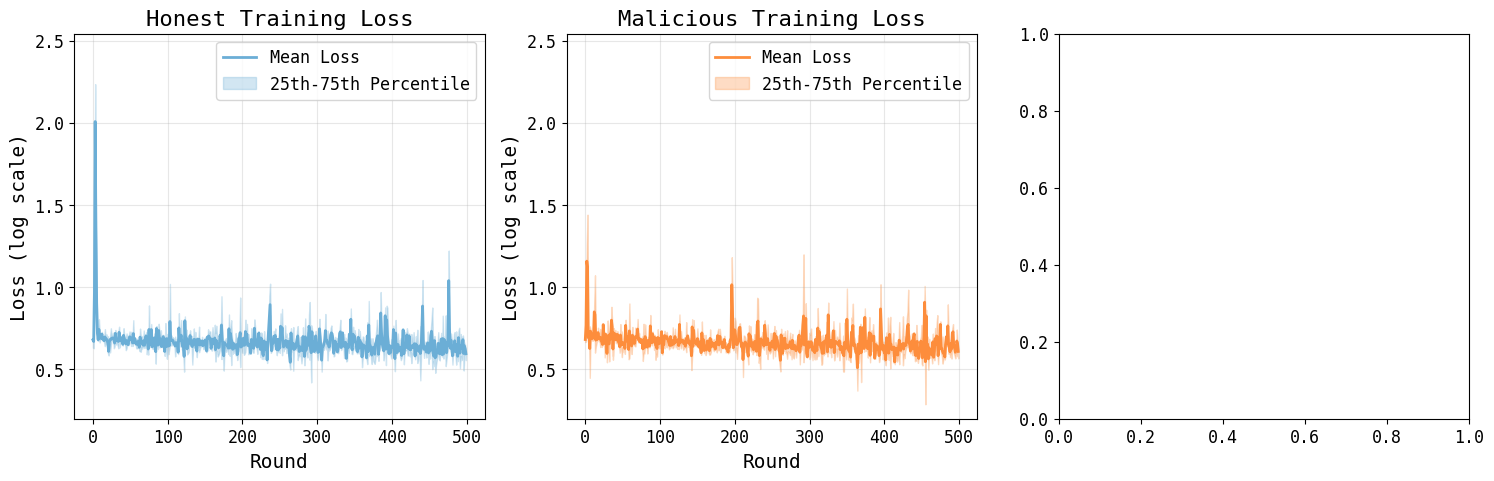

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def load_run_data(save_name):
    """Load metrics for a single run."""
    losses_df = pd.read_csv(f"{save_name}_losses.csv")
    rounds = losses_df['round'].values
    losses_array = losses_df.drop('round', axis=1).values
    return rounds, losses_array

plt.rcParams.update({
    "font.family": "monospace",
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Color scheme - Paired palette (colorblind-safe)
color_palette = sns.color_palette(palette='tab20c')
color_good = color_palette[1]      # light blue
color_bad = color_palette[5]       # light orange

# Load both runs
save_name_honest = "./results/twitter_honest"
save_name_byz = "./results/twitter_byzantine"

rounds_honest, losses_honest = load_run_data(save_name_honest)
rounds_byz, losses_byz = load_run_data(save_name_byz)

# Calculate statistics for both
mean_honest = losses_honest.mean(axis=1)
p25_honest = np.percentile(losses_honest, 25, axis=1)
p75_honest = np.percentile(losses_honest, 75, axis=1)

mean_byz = losses_byz.mean(axis=1)
p25_byz = np.percentile(losses_byz, 25, axis=1)
p75_byz = np.percentile(losses_byz, 75, axis=1)

# Calculate shared y-axis limits
all_losses = np.concatenate([losses_honest.flatten(), losses_byz.flatten()])
y_min, y_max = all_losses.min(), all_losses.max()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Honest training loss
axes[0].plot(rounds_honest, mean_honest, label="Mean Loss", color=color_good, linewidth=2)
axes[0].fill_between(rounds_honest, p25_honest, p75_honest, alpha=0.3, color=color_good, label="25th-75th Percentile")
axes[0].set_ylim(y_min, y_max)
axes[0].set_title("Honest Training Loss")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss (log scale)")
axes[0].legend()
axes[0].grid(alpha=0.3, which='both')

# Plot 2: Byzantine training loss
axes[1].plot(rounds_byz, mean_byz, label="Mean Loss", color=color_bad, linewidth=2)
axes[1].fill_between(rounds_byz, p25_byz, p75_byz, alpha=0.3, color=color_bad, label="25th-75th Percentile")
axes[1].set_ylim(y_min, y_max)
axes[1].set_title("Malicious Training Loss")
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Loss (log scale)")
axes[1].legend()
axes[1].grid(alpha=0.3, which='both')

# Plot 3: Final loss comparison - grouped bars
client_ids = list(final_loss_honest.keys())
losses_honest_final = [float(final_loss_honest[cid]) for cid in client_ids]
losses_byz_final = [float(final_loss_byz[cid]) for cid in client_ids]

x = np.arange(len(client_ids))
width = 0.35

axes[2].bar(x - width/2, losses_honest_final, width, label='Only Honest Clients', color=color_good, alpha=0.7, edgecolor='white')
axes[2].bar(x + width/2, losses_byz_final, width, label='With One Malicious client', color=color_bad, alpha=0.7, edgecolor='white', hatch='//')

axes[2].set_xlabel('Clients')
axes[2].set_ylabel('Final Test Loss')
axes[2].set_title('Final Test Loss Comparison')
axes[2].set_xticks(x)
for i in range(len(client_ids) - 1):
    client_ids[i] = f"honest_{i}"
client_ids[-1] = "malicious"
axes[2].set_xticklabels(client_ids, rotation=45, ha='right')
axes[2].legend(loc='lower right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
fig_filename = "./results/twitter_comparison"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

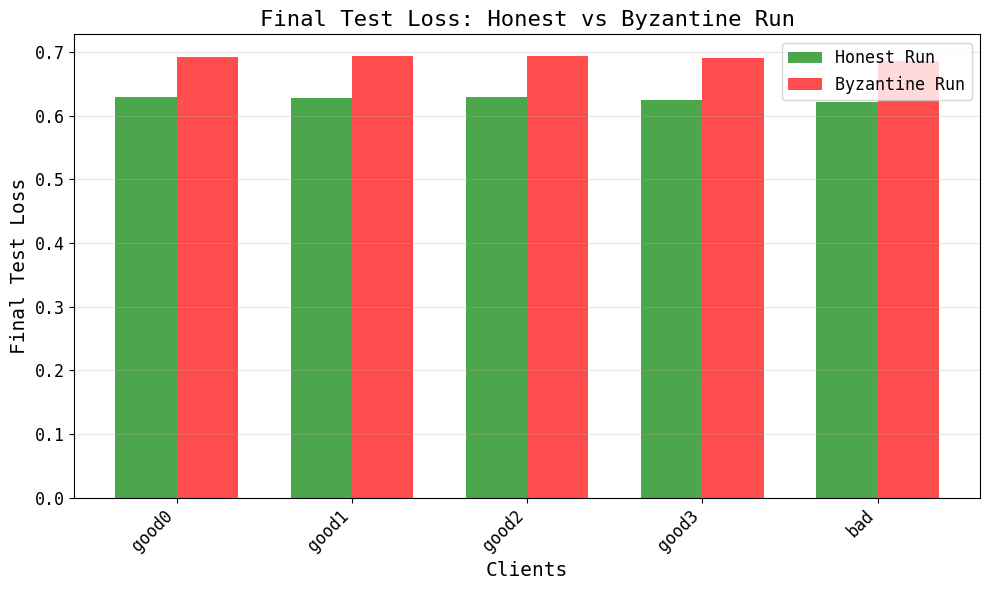

In [ ]:
# Get client IDs
client_ids = list(final_loss_honest.keys())

# Extract losses
losses_honest = [float(final_loss_honest[cid]) for cid in client_ids]
losses_byz = [float(final_loss_byz[cid]) for cid in client_ids]

# Set up bar positions
x = np.arange(len(client_ids))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Create grouped bars
bars1 = ax.bar(
    x - width / 2, losses_honest, width, label="Honest Run", color="green", alpha=0.7
)
bars2 = ax.bar(
    x + width / 2, losses_byz, width, label="Byzantine Run", color="red", alpha=0.7
)

# Customize with larger fonts
ax.set_xlabel("Clients", fontfamily="monospace", fontsize=14)
ax.set_ylabel("Final Test Loss", fontfamily="monospace", fontsize=14)
ax.set_title(
    "Final Test Loss: Honest vs Byzantine Run", fontfamily="monospace", fontsize=16
)
ax.set_xticks(x)
ax.set_xticklabels(
    client_ids, rotation=45, ha="right", fontfamily="monospace", fontsize=12
)
ax.legend(prop={"family": "monospace", "size": 12})
ax.grid(axis="y", alpha=0.3)

# Make tick labels monospace and larger
for label in ax.get_yticklabels():
    label.set_fontfamily("monospace")
    label.set_fontsize(12)

plt.tight_layout()
plt.savefig("final_loss_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    # "gradient_norms": grad_norms_array,
}

with open("strategicflsim_demo_shakespeare.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicflsim_demo_shakespeare.pkl")